In [14]:
#!pip install graphviz
from typing import Union, Tuple, List, Set, Callable
from graphviz import Digraph

from candle.engine import Value
from candle.nn import Neuron, Layer, MLP

In [15]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        #dot.node(name=str(id(n)), label = "{ data %.4f | grad}" % (n.data), shape='record')

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [16]:
def sum_squared_error(y_gts, y_preds):
    loss = sum((y_gt - y_pred)**2 for y_gt,y_pred in zip(y_gts, y_preds))
    return loss

def mean_squared_error(y_gts, y_preds):
    loss = (sum((y_gt - y_pred)**2 for y_gt,y_pred in zip(y_gts, y_preds)))/ len(y_gts)
    return loss

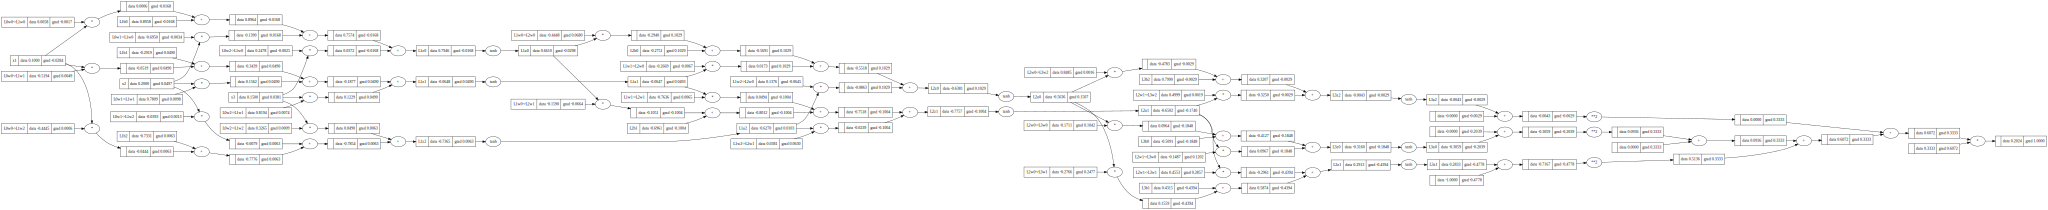

In [17]:
mlp = MLP(3, [3, 2, 3])
x1 = Value(0.1); x1.label = "x1"
x2 = Value(0.2); x2.label = "x2"
x3 = Value(0.15); x3.label ="x3"
x = [x1, x2, x3]
#x = [0.1, 0.2, 0.15]
y = [0.0, 1.0, 0.0]
o = mlp(x)
l = mean_squared_error(o, y)
l.backward()
draw_dot(l)

In [4]:
a = Value(0.4)
b = Value(0.5)
c = a + b
d = 0.4 * c
e = d.tanh()


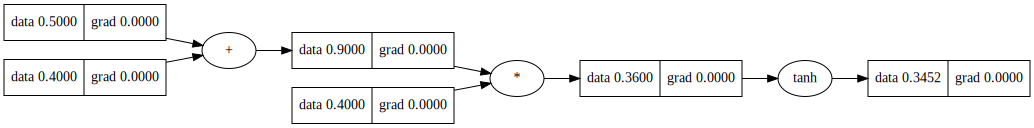

In [5]:
draw_dot(e)

In [21]:
e.grad = 1.0
e.backward()


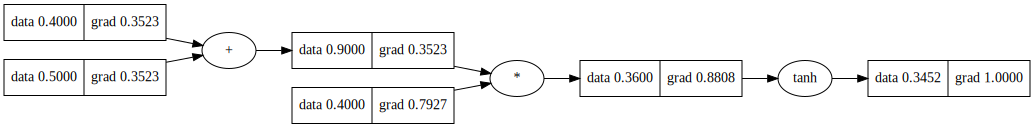

In [22]:
draw_dot(e)